In [5]:
import io
import zipfile
import requests
import frontmatter
import logging

def read_repo_data(repo_owner, repo_name, branch="main"):
    """
    Download and parse all markdown files from a GitHub repository.
    
    Args:
        repo_owner (str): GitHub username or organization
        repo_name (str): Repository name
        branch (str): Branch name (default: main)
    
    Returns:
        List[dict]: File content + frontmatter + metadata
    """
    url = f"https://codeload.github.com/{repo_owner}/{repo_name}/zip/refs/heads/{branch}"
    resp = requests.get(url)

    if resp.status_code == 404 and branch == "main":
        # Try fallback to master
        return read_repo_data(repo_owner, repo_name, branch="master")
    
    if resp.status_code != 200:
        raise Exception(f"Failed to download repository: HTTP {resp.status_code}")

    repository_data = []
    with zipfile.ZipFile(io.BytesIO(resp.content)) as zf:
        for file_info in zf.infolist():
            filename = file_info.filename
            if not filename.lower().endswith((".md", ".mdx")):
                continue
            try:
                with zf.open(file_info) as f_in:
                    content = f_in.read().decode("utf-8", errors="replace")
                    post = frontmatter.loads(content)
                    data = post.to_dict()
                    data.update({
                        "filename": filename,
                        "repo": repo_name,
                        "owner": repo_owner,
                        "branch": branch
                    })
                    repository_data.append(data)
            except Exception as e:
                logging.warning("Error processing %s: %s", filename, e)
                continue

    return repository_data

In [8]:
dtc_faq = read_repo_data('DataTalksClub', 'faq')
print(f"FAQ documents: {len(dtc_faq)}")


FAQ documents: 1217


In [3]:
def sliding_window(seq, size, step):
    if size <= 0 or step <= 0:
        raise ValueError("size and step must be positive")
    n = len(seq)
    result = []
    for i in range(0, n, step):
        chunk = seq[i:i+size]
        result.append({'start': i, 'chunk': chunk})
        if i + size >= n:
            break   
    return result

In [18]:
import json
import re

data = list(dtc_faq)
windows = sliding_window(data, size=4, step=2)

with open("windows_chuncks.json", "w") as f:
    json.dump(windows, f, indent=2)

In [19]:
def split_by_paragraphs(text):
    paragraphs = re.split(r"\n\s*\n", text.strip())
    return [p.strip() for p in paragraphs if p.strip()]

def split_markdown_by_level(text, max_level=2):
    header_pattern = rf"^(#{1,{max_level}})\s+(.+)$"
    pattern = re.compile(header_pattern, re.MULTILINE)
    parts = pattern.split(text)

    sections = []
    for i in range(1, len(parts), 3):
        hashes = parts[i]
        header = parts[i + 1]
        content = parts[i + 2].strip() if i + 2 < len(parts) else ""
        section_text = f"{hashes} {header}".strip()
        if content:
            section_text += f"\n\n{content}"
        sections.append(section_text)
    return sections

In [20]:
# Pick the first file with some actual content
sample = next((d for d in dtc_faq if len(d["content"]) > 200), None)

if not sample:
    print("No suitable file found!")
else:
    print(f"\n--- Sample file: {sample['filename']} ---\n")
    text = sample["content"]

    # Paragraph chunks
    paragraphs = split_by_paragraphs(text)
    print(f"Found {len(paragraphs)} paragraphs. Preview:\n")
    for p in paragraphs[:3]:
        print("----\n", p)

    # Section chunks
    sections = split_markdown_by_level(text, max_level=2)
    print(f"\nFound {len(sections)} sections. Preview:\n")
    for s in sections[:3]:
        print("====\n", s[:300], "...")


--- Sample file: faq-main/_questions/data-engineering-zoomcamp/general/001_9e508f2212_course-when-does-the-course-start.md ---

Found 2 paragraphs. Preview:

----
 The next cohort starts January 13th, 2025. More info at [DTC](https://datatalks.club/blog/guide-to-free-online-courses-at-datatalks-club.html).
----
 - Register before the course starts using this [link](https://airtable.com/shr6oVXeQvSI5HuWD).
- Join the [course Telegram channel with announcements](https://t.me/dezoomcamp).
- Don’t forget to register in DataTalks.Club's Slack and join the channel.

Found 0 sections. Preview:



In [26]:
import re
import json
import statistics
from typing import List, Dict, Any
import matplotlib.pyplot as plt
from collections import Counter

def combine_chunk_content(chunk_items, field='content'):
    """
    Combine content from multiple items in a chunk.
    
    Args:
        chunk_items: List of items (docs, paragraphs, etc.)
        field: Field name to extract (for dicts) or None for strings
    
    Returns:
        Combined text string
    """
    if not chunk_items:
        return ""
    
    # Handle list of strings
    if isinstance(chunk_items[0], str):
        return "\n\n".join(chunk_items)
    
    # Handle list of dicts
    if isinstance(chunk_items[0], dict):
        texts = []
        for item in chunk_items:
            if field in item:
                texts.append(item[field])
        return "\n\n".join(texts)
    
    return str(chunk_items)

def analyze_chunks(chunks: List, chunk_type: str = "Unknown") -> Dict[str, Any]:
    """
    Analyze characteristics of chunks.
    Handles both string chunks and sliding window chunks.
    """
    if not chunks:
        return {"error": "No chunks to analyze", "chunk_type": chunk_type}
    
    # Extract text content from chunks
    texts = []
    for chunk in chunks:
        if isinstance(chunk, str):
            texts.append(chunk)
        elif isinstance(chunk, dict) and 'chunk' in chunk:
            # Handle sliding window output
            combined = combine_chunk_content(chunk['chunk'])
            texts.append(combined)
        else:
            texts.append(str(chunk))
    
    # Filter out empty texts
    texts = [t for t in texts if t and t.strip()]
    
    if not texts:
        return {"error": "All chunks are empty", "chunk_type": chunk_type}
    
    lengths = [len(text) for text in texts]
    word_counts = [len(text.split()) for text in texts]
    
    analysis = {
        "chunk_type": chunk_type,
        "total_chunks": len(chunks),
        "non_empty_chunks": len(texts),
        "char_stats": {
            "min": min(lengths) if lengths else 0,
            "max": max(lengths) if lengths else 0,
            "mean": statistics.mean(lengths) if lengths else 0,
            "median": statistics.median(lengths) if lengths else 0,
            "std": statistics.stdev(lengths) if len(lengths) > 1 else 0
        },
        "word_stats": {
            "min": min(word_counts) if word_counts else 0,
            "max": max(word_counts) if word_counts else 0,
            "mean": statistics.mean(word_counts) if word_counts else 0,
            "median": statistics.median(word_counts) if word_counts else 0,
            "std": statistics.stdev(word_counts) if len(word_counts) > 1 else 0
        },
        "empty_chunks": len(chunks) - len(texts),
        "very_short_chunks": sum(1 for t in texts if len(t) < 50),
        "very_long_chunks": sum(1 for t in texts if len(t) > 2000)
    }
    
    return analysis

def visualize_chunk_distribution(analyses: List[Dict[str, Any]]):
    """
    Create visualizations comparing different chunking strategies.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot 1: Number of chunks
    chunk_types = [a["chunk_type"] for a in analyses]
    chunk_counts = [a["total_chunks"] for a in analyses]
    
    axes[0, 0].bar(chunk_types, chunk_counts, color='skyblue')
    axes[0, 0].set_title('Number of Chunks by Strategy')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Average chunk size (characters)
    avg_sizes = [a["char_stats"]["mean"] for a in analyses]
    
    axes[0, 1].bar(chunk_types, avg_sizes, color='lightcoral')
    axes[0, 1].set_title('Average Chunk Size (characters)')
    axes[0, 1].set_ylabel('Characters')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Chunk size distribution (box plot)
    all_char_data = []
    labels = []
    for a in analyses:
        if a["chunk_type"] != "Unknown":
            all_char_data.append([a["char_stats"]["min"], 
                                 a["char_stats"]["mean"], 
                                 a["char_stats"]["max"]])
            labels.append(a["chunk_type"])
    
    axes[1, 0].boxplot(all_char_data, labels=labels)
    axes[1, 0].set_title('Chunk Size Distribution')
    axes[1, 0].set_ylabel('Characters')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Word count statistics
    word_means = [a["word_stats"]["mean"] for a in analyses]
    word_stds = [a["word_stats"]["std"] for a in analyses]
    
    axes[1, 1].bar(chunk_types, word_means, yerr=word_stds, 
                   color='lightgreen', capsize=5)
    axes[1, 1].set_title('Average Word Count per Chunk')
    axes[1, 1].set_ylabel('Words')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def test_chunking_strategies(documents: List[Dict], sample_size: int = 5):
    """
    Test different chunking strategies on sample documents.
    Including sliding window on documents and paragraphs.
    """
    # Select sample documents
    sample_docs = [d for d in documents if len(d.get("content", "")) > 500][:sample_size]
    
    if not sample_docs:
        print("No suitable documents found for testing")
        return
    
    print(f"Testing on {len(sample_docs)} documents\n")
    
    all_chunks = {
        "paragraphs": [],
        "sections_h2": [],
        "sections_h3": [],
        "sliding_docs_2_1": [],  # Window of 2 docs, step 1
        "sliding_docs_3_2": [],  # Window of 3 docs, step 2
        "sliding_para_3_2": []   # Window of 3 paragraphs, step 2
    }
    
    # Traditional chunking on individual documents
    all_paragraphs = []
    for doc in sample_docs:
        content = doc.get("content", "")
        
        # Traditional strategies
        paragraphs = split_by_paragraphs(content)
        all_chunks["paragraphs"].extend(paragraphs)
        all_paragraphs.extend(paragraphs)
        
        all_chunks["sections_h2"].extend(split_markdown_by_level(content, max_level=2))
        all_chunks["sections_h3"].extend(split_markdown_by_level(content, max_level=3))
    
    # Sliding window on documents
    all_chunks["sliding_docs_2_1"] = sliding_window(sample_docs, size=2, step=1)
    all_chunks["sliding_docs_3_2"] = sliding_window(sample_docs, size=3, step=2)
    
    # Sliding window on paragraphs
    if all_paragraphs:
        all_chunks["sliding_para_3_2"] = sliding_window(all_paragraphs, size=3, step=2)
    
    # Analyze each strategy
    analyses = []
    for strategy, chunks in all_chunks.items():
        analysis = analyze_chunks(chunks, strategy)
        
        print(f"\n{'='*50}")
        print(f"Strategy: {strategy}")
        print(f"{'='*50}")
        
        # Check if analysis contains an error
        if "error" in analysis:
            print(f"Error: {analysis['error']}")
            continue
            
        analyses.append(analysis)
        
        print(f"Total chunks: {analysis['total_chunks']}")
        print(f"Character length - Mean: {analysis['char_stats']['mean']:.0f}, "
              f"Min: {analysis['char_stats']['min']}, Max: {analysis['char_stats']['max']}")
        print(f"Word count - Mean: {analysis['word_stats']['mean']:.0f}, "
              f"Min: {analysis['word_stats']['min']}, Max: {analysis['word_stats']['max']}")
        print(f"Very short chunks (<50 chars): {analysis['very_short_chunks']}")
        print(f"Very long chunks (>2000 chars): {analysis['very_long_chunks']}")
        
        # Add overlap info for sliding windows
        if "sliding" in strategy:
            if "_docs_" in strategy:
                window_size, step = map(int, strategy.split("_docs_")[1].split("_"))
                overlap = max(0, window_size - step)
                print(f"Window overlap: {overlap} documents")
            elif "_para_" in strategy:
                window_size, step = map(int, strategy.split("_para_")[1].split("_"))
                overlap = max(0, window_size - step)
                print(f"Window overlap: {overlap} paragraphs")
    
    # Visualize results (only if we have valid analyses)
    if analyses:
        visualize_chunk_distribution(analyses)
    else:
        print("\nNo valid analyses to visualize.")
    
    return analyses, all_chunks

def test_sliding_window_overlap(sequence: List, window_sizes: List[tuple] = [(2,1), (3,2), (4,2), (5,3)]):
    """
    Test how different sliding window parameters affect chunking.
    
    Args:
        sequence: List of items to chunk (documents, paragraphs, etc.)
        window_sizes: List of (size, step) tuples to test
    """
    print(f"Testing sliding window on sequence of {len(sequence)} items:\n")
    print(f"{'Config':<15} {'Chunks':<10} {'Overlap':<10} {'Coverage':<10}")
    print("-" * 45)
    
    for size, step in window_sizes:
        chunks = sliding_window(sequence, size, step)
        overlap = max(0, size - step)
        coverage = (size + (len(chunks) - 1) * step) / len(sequence)
        
        print(f"size={size},step={step:<7} {len(chunks):<10} {overlap:<10} {coverage:.2f}x")
        
        # Show sample chunk info
        if chunks and len(chunks) > 1:
            first_chunk_len = len(combine_chunk_content(chunks[0]['chunk']))
            second_chunk_len = len(combine_chunk_content(chunks[1]['chunk']))
            print(f"  → First chunk: {first_chunk_len} chars, "
                  f"Second chunk: {second_chunk_len} chars")

def compare_document_vs_paragraph_windows(documents: List[Dict]):
    """
    Compare sliding windows on documents vs paragraphs.
    """
    print("Comparing Document-level vs Paragraph-level sliding windows\n")
    
    # Extract all paragraphs
    all_paragraphs = []
    for doc in documents[:20]:  # Sample
        content = doc.get("content", "")
        paragraphs = split_by_paragraphs(content)
        all_paragraphs.extend(paragraphs)
    
    print(f"Total documents: {len(documents[:20])}")
    print(f"Total paragraphs: {len(all_paragraphs)}\n")
    
    # Test document-level windows
    print("DOCUMENT-LEVEL WINDOWS:")
    doc_windows = sliding_window(documents[:20], size=3, step=2)
    doc_analysis = analyze_chunks(doc_windows, "doc_windows")
    print(f"  Chunks: {doc_analysis['total_chunks']}")
    print(f"  Avg size: {doc_analysis['char_stats']['mean']:.0f} chars")
    print(f"  Size range: {doc_analysis['char_stats']['min']}-{doc_analysis['char_stats']['max']} chars\n")
    
    # Test paragraph-level windows
    print("PARAGRAPH-LEVEL WINDOWS:")
    para_windows = sliding_window(all_paragraphs, size=5, step=3)
    para_analysis = analyze_chunks(para_windows, "para_windows")
    print(f"  Chunks: {para_analysis['total_chunks']}")
    print(f"  Avg size: {para_analysis['char_stats']['mean']:.0f} chars")
    print(f"  Size range: {para_analysis['char_stats']['min']}-{para_analysis['char_stats']['max']} chars\n")
    
    print("RECOMMENDATION:")
    if doc_analysis['char_stats']['std'] < para_analysis['char_stats']['std']:
        print("  → Document-level windows provide more consistent chunk sizes")
    else:
        print("  → Paragraph-level windows provide more consistent chunk sizes")
    
    if doc_analysis['very_long_chunks'] > 0:
        print("  → Consider paragraph-level for better size control")
    elif para_analysis['very_short_chunks'] > len(para_windows) * 0.1:
        print("  → Consider document-level to avoid too many small chunks")



Testing on 10 documents


Strategy: paragraphs
Total chunks: 51
Character length - Mean: 160, Min: 16, Max: 576
Word count - Mean: 22, Min: 1, Max: 50
Very short chunks (<50 chars): 9
Very long chunks (>2000 chars): 0

Strategy: sections_h2
Error: No chunks to analyze

Strategy: sections_h3
Error: No chunks to analyze

Strategy: sliding_docs_2_1
Total chunks: 9
Character length - Mean: 1518, Min: 1268, Max: 2576
Word count - Mean: 200, Min: 126, Max: 383
Very short chunks (<50 chars): 0
Very long chunks (>2000 chars): 1
Window overlap: 1 documents

Strategy: sliding_docs_3_2
Total chunks: 5
Character length - Mean: 2208, Min: 2006, Max: 2576
Word count - Mean: 294, Min: 210, Max: 383
Very short chunks (<50 chars): 0
Very long chunks (>2000 chars): 5
Window overlap: 1 documents

Strategy: sliding_para_3_2
Total chunks: 25
Character length - Mean: 523, Min: 302, Max: 957
Word count - Mean: 72, Min: 45, Max: 102
Very short chunks (<50 chars): 0
Very long chunks (>2000 chars): 0
Window ove

/tmp/ipykernel_4851/3816167628.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(all_char_data, labels=labels)


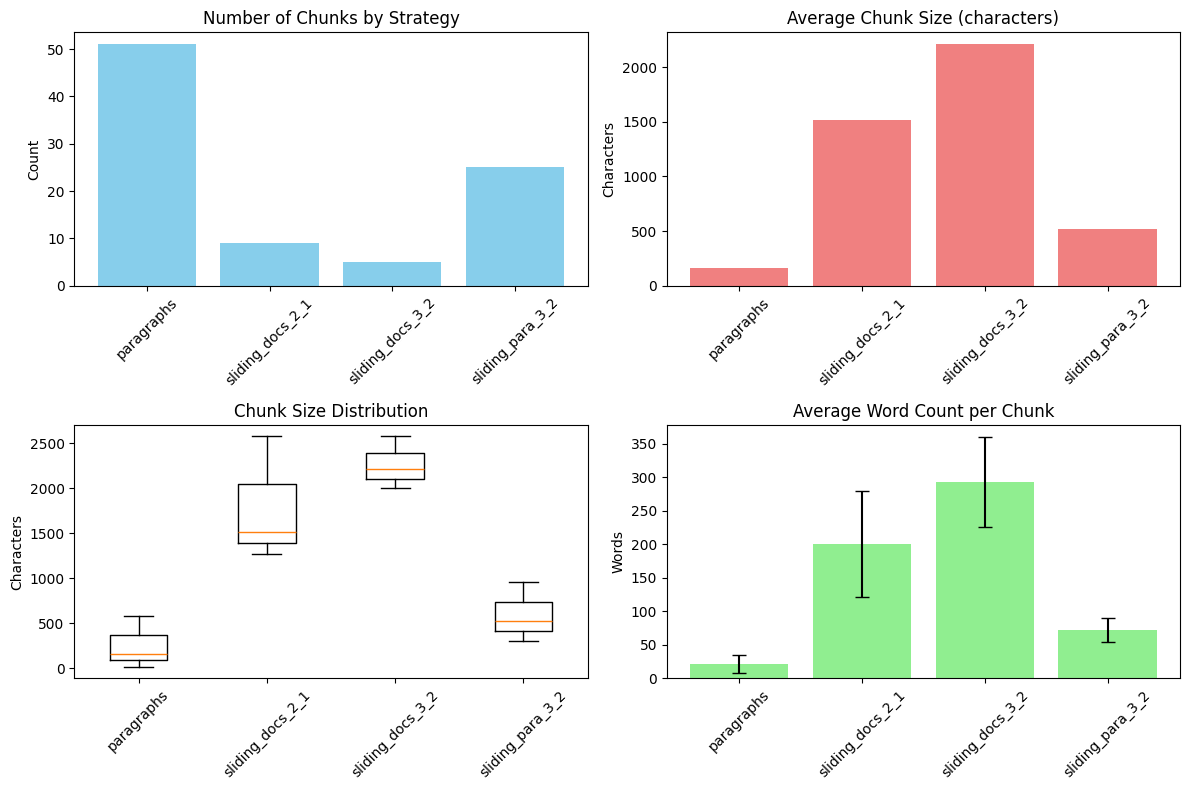

Testing sliding window on sequence of 20 items:

Config          Chunks     Overlap    Coverage  
---------------------------------------------
size=2,step=1       19         1          1.00x
  → First chunk: 444 chars, Second chunk: 722 chars
size=3,step=2       10         1          1.05x
  → First chunk: 770 chars, Second chunk: 735 chars
size=4,step=2       9          2          1.00x
  → First chunk: 995 chars, Second chunk: 1001 chars
size=5,step=3       6          2          1.00x
  → First chunk: 1181 chars, Second chunk: 1982 chars
Comparing Document-level vs Paragraph-level sliding windows

Total documents: 20
Total paragraphs: 45

DOCUMENT-LEVEL WINDOWS:
  Chunks: 10
  Avg size: 1110 chars
  Size range: 735-1557 chars

PARAGRAPH-LEVEL WINDOWS:
  Chunks: 15
  Avg size: 814 chars
  Size range: 498-1199 chars

RECOMMENDATION:
  → Paragraph-level windows provide more consistent chunk sizes
Your existing chunks: {'chunk_type': 'existing_4_2', 'total_chunks': 608, 'non_empty_chunk

In [27]:
# 1. Test all strategies including sliding windows
analyses, chunks = test_chunking_strategies(dtc_faq, sample_size=10)

# 2. Test different sliding window configurations
test_sliding_window_overlap(dtc_faq[:20])

# 3. Compare document-level vs paragraph-level windows
compare_document_vs_paragraph_windows(dtc_faq)

# 4. Create paragraph-based sliding windows
all_paras = []
for doc in dtc_faq[:50]:
    all_paras.extend(split_by_paragraphs(doc['content']))
para_windows = sliding_window(all_paras, size=5, step=3)

# 5. Test your existing window chunks from the notebook
with open("windows_chuncks.json", "r") as f:
    existing_windows = json.load(f)
analysis = analyze_chunks(existing_windows, "existing_4_2")
print(f"Your existing chunks: {analysis}")